
Best Feature Weights:
Cuisine_Type: 0.1176
Ingredients_List: 0.1176
Preparation_Steps: 0.1176
Numeric_Features: 0.6471
Average Similarity Score: 0.9942

Best NDCG Score: 0.5000

User clicked R010，Recommend recipes：
Recipe_ID Cuisine_Type  Cooking_Time_Minutes  Cost_Per_Serving  Popularity_Score  Similarity_Score
    R2953      Mexican                    23             16.94               240          0.999077
    R1765      Mexican                    24             18.62               286          0.998067
    R3118      Mexican                    18             17.84               297          0.993748
    R4164      Mexican                    15             18.59               250          0.990740
    R2252      Mexican                    19             15.95               182          0.989320


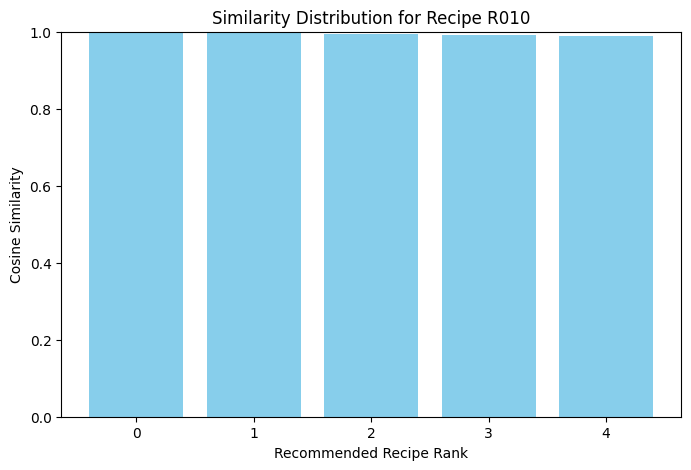

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score

df = pd.read_csv("recipe_processed.csv")
df.drop(columns=['Recipe_Name'], inplace=True)

cuisine_encoder = OneHotEncoder(sparse_output=False)
cuisine_encoded = cuisine_encoder.fit_transform(df[['Cuisine_Type']])

tfidf_ingredients = TfidfVectorizer()
ingredients_matrix = tfidf_ingredients.fit_transform(df['Ingredients_List']).toarray()

tfidf_steps = TfidfVectorizer()
steps_matrix = tfidf_steps.fit_transform(df['Preparation_Steps']).toarray()

scaler = MinMaxScaler()
numeric_features = df[['Cooking_Time_Minutes', 'Calories_Per_Serving', 'Cost_Per_Serving', 'Popularity_Score']]
numeric_scaled = scaler.fit_transform(numeric_features)

num_cuisine = cuisine_encoded.shape[1]
num_ingredients = ingredients_matrix.shape[1]
num_steps = steps_matrix.shape[1]
num_numeric = numeric_scaled.shape[1]
total_features = num_cuisine + num_ingredients + num_steps + num_numeric

def optimize_weights():
    best_weights = None
    best_ndcg = -1

    weight_values = np.linspace(0.1, 1.0, 5)
    for w_cuisine, w_ingredients, w_steps, w_numeric in product(weight_values, repeat=4):
        total_w = w_cuisine + w_ingredients + w_steps + w_numeric
        weights = np.array([w_cuisine, w_ingredients, w_steps, w_numeric]) / total_w

        recipe_features = np.hstack((
            cuisine_encoded * weights[0],
            ingredients_matrix * weights[1],
            steps_matrix * weights[2],
            numeric_scaled * weights[3]
        ))

        similarity_matrix = cosine_similarity(recipe_features)

        clicked_recipe = "R010"
        recommended_recipes = get_recommendations(clicked_recipe, df, similarity_matrix)
        ndcg = compute_ndcg(recommended_recipes.index, [1, 0, 0, 0, 0])

        if ndcg > best_ndcg:
            best_ndcg = ndcg
            best_weights = weights

    return best_weights, best_ndcg
def get_recommendations(recipe_id, df, similarity_matrix, K=5):
    recipe_index = df.index[df['Recipe_ID'] == recipe_id].tolist()[0]
    similarities = similarity_matrix[recipe_index]
    recommended_indices = np.argsort(-similarities)[1:K + 1]
    recommended_df = df.iloc[recommended_indices].copy()
    recommended_df['Similarity_Score'] = similarities[recommended_indices]

    return recommended_df[['Recipe_ID', 'Cuisine_Type', 'Cooking_Time_Minutes',
                           'Cost_Per_Serving', 'Popularity_Score', 'Similarity_Score']]

def compute_avg_similarity(clicked_recipe, similarity_matrix, df, K=5):
    recipe_index = df.index[df['Recipe_ID'] == clicked_recipe].tolist()[0]
    recommended_indices = np.argsort(-similarity_matrix[recipe_index])[1:K + 1]

    similarities = similarity_matrix[recipe_index, recommended_indices]
    avg_similarity = np.mean(similarities)

    return avg_similarity, similarities

def compute_ndcg(recommended_indices, true_relevance):
    return ndcg_score([true_relevance], [recommended_indices])

best_weights, best_ndcg = optimize_weights()

recipe_features = np.hstack((
    cuisine_encoded * best_weights[0],
    ingredients_matrix * best_weights[1],
    steps_matrix * best_weights[2],
    numeric_scaled * best_weights[3]
))

similarity_matrix = cosine_similarity(recipe_features)

clicked_recipe = "R010"
recommended_recipes = get_recommendations(clicked_recipe, df, similarity_matrix)
avg_similarity, similarities = compute_avg_similarity(clicked_recipe, similarity_matrix, df)

print("\nBest Feature Weights:")
print(f"Cuisine_Type: {best_weights[0]:.4f}")
print(f"Ingredients_List: {best_weights[1]:.4f}")
print(f"Preparation_Steps: {best_weights[2]:.4f}")
print(f"Numeric_Features: {best_weights[3]:.4f}")
print(f"Average Similarity Score: {avg_similarity:.4f}\n")
print(f"Best NDCG Score: {best_ndcg:.4f}\n")


pd.set_option("display.max_columns", None)
print(f"User clicked {clicked_recipe}，Recommend recipes：")
print(recommended_recipes.to_string(index=False))

plt.figure(figsize=(8, 5))
plt.bar(range(len(recommended_recipes)), recommended_recipes['Similarity_Score'], color='skyblue')
plt.xlabel("Recommended Recipe Rank")
plt.ylabel("Cosine Similarity")
plt.title(f"Similarity Distribution for Recipe {clicked_recipe}")
plt.ylim(0, 1)
plt.show()
